# Analyse epipolar distributions

## Notebook parameters

Those parameters need to be set before running the notebook.

In [5]:
# Path to the cars folder
cars_home = "TODO"
# Path to the directory containing the content.json file of the prepare step output
content_dir = "TODO"

## Imports

In [7]:
### Trick to override cars version
import sys
sys.path = [cars_home] + sys.path
import os
import json
import logging
os.environ['OTB_APPLICATION_PATH'] = os.path.join(cars_home,'build','lib','otb','applications')+':'+os.environ['OTB_APPLICATION_PATH']
###
import numpy as np
from scipy import stats
import matplotlib as mp
import matplotlib.pyplot as plt


## Reading matches data

First, we load matches data with numpy

In [9]:
with open(os.path.join(content_dir,'content.json'), "r", encoding="utf8") as fstream:
    conf = json.load(fstream)

matches_path = conf['applications']["left_right"]['disparity_range_computation_run']['matches']
raw_matches_path = conf['applications']["left_right"]['matches_filtering']['raw_matches']

if matches_path is None or  raw_matches_path is None:
    logging.error("Matches not generated")
    
matches = np.load(matches_path)
raw_matches = np.load(raw_matches_path)
cars_disp_min = conf['applications']["left_right"]['disparity_range_computation_run']['minimum_disparity']
cars_disp_max = conf['applications']["left_right"]['disparity_range_computation_run']['maximum_disparity']


From matches we can compute the epipolar error and disparity

In [10]:
epipolar_error = matches[:,1] - matches[:,3]
raw_epipolar_error = raw_matches[:,1] - raw_matches[:,3]
disparity = matches[:,2] - matches[:,0]
raw_disparity = raw_matches[:,2] - raw_matches[:,0]

In [11]:
print('Disparity range as computed by cars: [{}, {}]'.format(cars_disp_min, cars_disp_max))

Disparity range as computed by cars: [-19.1309941482544, 14.469958961486832]


## Distribution of epipolar error and disparity

Lets have a look at distributions of epipolar error and disparity range. Red lines show the disparity range used. First we need to compute common bounds between raw and filtered matches.

In [12]:
raw_epipolar_error_min = np.percentile(raw_epipolar_error,1)
raw_epipolar_error_max = np.percentile(raw_epipolar_error,99)
epipolar_error_min = min(np.min(epipolar_error),raw_epipolar_error_min)
epipolar_error_max = max(np.max(epipolar_error), raw_epipolar_error_max)
raw_disparity_min = np.percentile(raw_disparity,1)
raw_disparity_max = np.percentile(raw_disparity,99)
disparity_min = min(np.min(disparity),raw_disparity_min)
disparity_max = max(np.max(disparity), raw_disparity_max)

Now we can plot distribution of epipolar error and disparity, for raw and filtered matches.

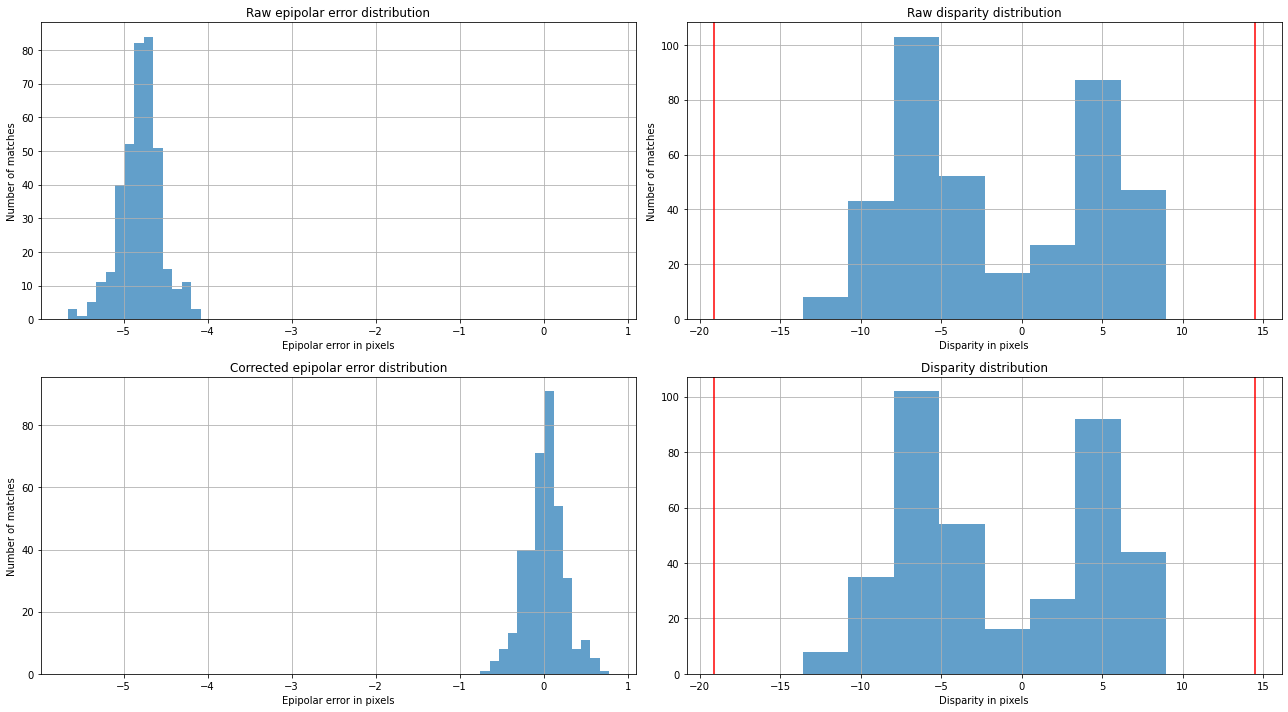

In [13]:
# resolution of histogram
hist_resolution = 'scott'
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(18,10))
ax0.set_title("Raw epipolar error distribution")
ax0.set_xlabel("Epipolar error in pixels")
ax0.set_ylabel("Number of matches")
ax0.grid(True)
n, bins, patches = ax0.hist(raw_epipolar_error, hist_resolution, alpha=0.7, range =(epipolar_error_min, epipolar_error_max), histtype='stepfilled')

ax2.set_title("Corrected epipolar error distribution")
ax2.set_xlabel("Epipolar error in pixels")
ax2.set_ylabel("Number of matches")
ax2.grid(True)
n, bins, patches = ax2.hist(epipolar_error, hist_resolution, alpha=0.7, range =(epipolar_error_min, epipolar_error_max), histtype='stepfilled')

ax1.set_title("Raw disparity distribution")
ax1.set_xlabel("Disparity in pixels")
ax1.set_ylabel("Number of matches")
ax1.axvline(cars_disp_min, color='red')
ax1.axvline(cars_disp_max, color='red')
ax1.grid(True)
n, bins, patches = ax1.hist(raw_disparity, hist_resolution, alpha=0.7, histtype='stepfilled', range=(disparity_min, disparity_max))

ax3.set_title("Disparity distribution")
ax3.set_xlabel("Disparity in pixels")
ax3.axvline(cars_disp_min, color='red')
ax3.axvline(cars_disp_max, color='red')
ax3.grid(True)
n, bins, patches = ax3.hist(disparity, hist_resolution, alpha=0.7, histtype='stepfilled', range=(disparity_min, disparity_max))

fig.tight_layout()

In [14]:
epipolar_error_mean = epipolar_error.mean()
epipolar_error_std = epipolar_error.std()
print("Residual epipolar error: mean = {} pixels, stdev = {} pixels".format(epipolar_error_mean, epipolar_error_std))

Residual epipolar error: mean = 0.01604209467768669 pixels, stdev = 0.2289392650127411 pixels


## Spatial distribution of epipolar error and disparity range

The following graphic show the spatial distribution of the epipolar error after grid correction by cars.

In [15]:
# This parameter can be changed for coarser or finer aggregation
bins = (100,100)

We compute the mean epipolar error in each bin.

In [16]:
clip_percentile=1
stats_epi_2d, xedges, yedges,nb = stats.binned_statistic_2d(matches[:, 0], matches[:, 1], epipolar_error, bins=bins, statistic="mean")
count_epi_2d, xedges, yedges,nb = stats.binned_statistic_2d(matches[:, 0], matches[:, 1], epipolar_error, bins=bins, statistic="count")

# Cell centers
x1d = (xedges[1:] + xedges[:-1])/2
y1d = (yedges[1:] + yedges[:-1])/2
x2d, y2d = np.meshgrid(x1d,y1d)

Now we can display the spatial distribution of the epipolar error

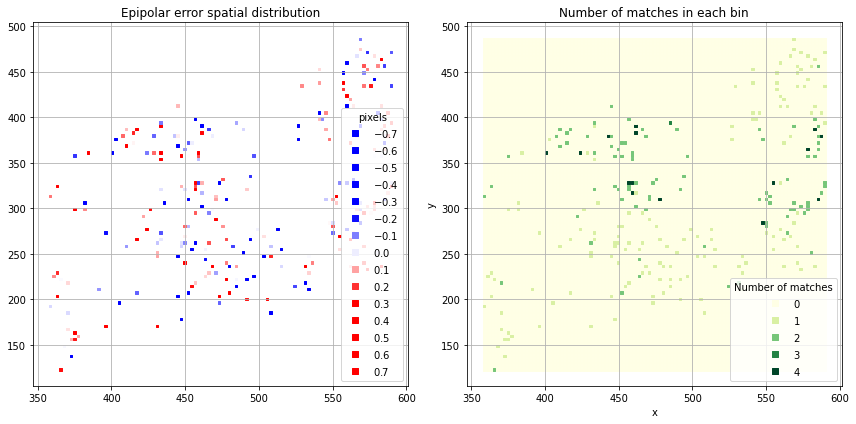

In [17]:
fig, (ax0,ax1) = plt.subplots(ncols=2,figsize=(12,6))
ax0.set_title("Epipolar error spatial distribution")
scatter0 = ax0.scatter(x2d.flatten(), y2d.flatten(), c = stats_epi_2d.flatten(), cmap='bwr' , marker='s',
                      vmin=epipolar_error_mean - epipolar_error_std, vmax=epipolar_error_mean + epipolar_error_std, s= 6)
ax0.legend(*scatter0.legend_elements(),loc='lower right', title='pixels')
scatter1 = ax1.scatter(x2d.flatten(), y2d.flatten(), c = count_epi_2d.flatten(), cmap='YlGn', marker='s', s= 6)
ax1.set_title("Number of matches in each bin")
ax1.legend(*scatter1.legend_elements(),loc='lower right', title='Number of matches')
plt.xlabel('x')
plt.ylabel('y')
ax0.grid(True)
ax1.grid(True)
fig.tight_layout()

Next, we compute disparity minimum, maximum and range width for each bin

In [18]:
stats_dispmin_2d, xedges, yedges,nb = stats.binned_statistic_2d(
matches[:, 0], matches[:, 1], disparity, bins=bins, statistic=np.min)
stats_dispmax_2d, xedges, yedges,nb = stats.binned_statistic_2d(
matches[:, 0], matches[:, 1], disparity, bins=bins, statistic=np.max)
disp_width = stats_dispmax_2d-stats_dispmin_2d
# Cell centers
x1d = (xedges[1:] + xedges[:-1])/2
y1d = (yedges[1:] + yedges[:-1])/2

x2d, y2d = np.meshgrid(x1d,y1d)

We can now display the spatial distribution of disparity

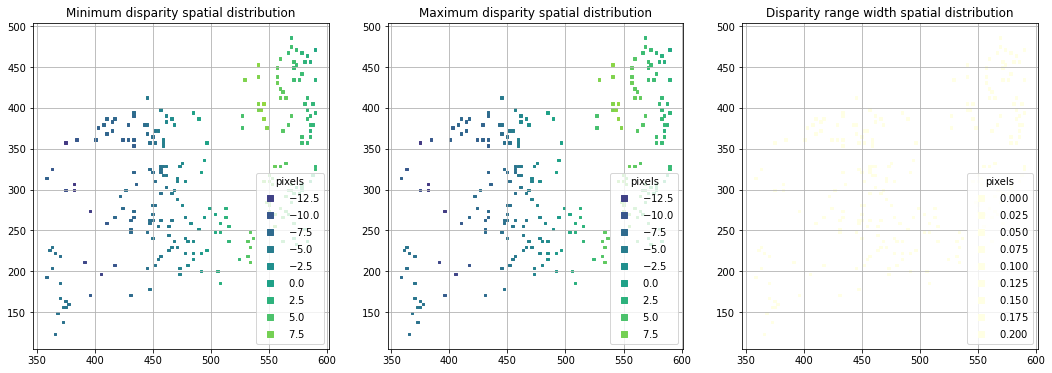

In [19]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,figsize=(18,6))

scatter0 = ax0.scatter(x2d.flatten(), y2d.flatten(), c = stats_dispmin_2d.flatten(), cmap='viridis', marker='s',
                      vmin=cars_disp_min, vmax=cars_disp_max, s= 6)
ax0.set_title("Minimum disparity spatial distribution")
ax0.legend(*scatter0.legend_elements(),loc='lower right', title='pixels')
ax0.grid(True)
scatter1 = ax1.scatter(x2d.flatten(), y2d.flatten(), c = stats_dispmax_2d.flatten(), cmap='viridis', marker='s',
                      vmin=cars_disp_min, vmax=cars_disp_max, s= 6)
ax1.set_title("Maximum disparity spatial distribution")
ax1.legend(*scatter1.legend_elements(),loc='lower right', title='pixels')
ax1.grid(True)
scatter2 = ax2.scatter(x2d.flatten(), y2d.flatten(), c = disp_width.flatten(), cmap='YlGn', marker='s',
                      vmin=0, vmax=cars_disp_max-cars_disp_min, s= 6)
ax2.set_title("Disparity range width spatial distribution")
try:
    ax2.legend(*scatter2.legend_elements(),loc='lower right', title='pixels')
except:
    print("Cannot plot legend for disparity range")
ax2.grid(True)